In [ ]:
# |default_exp lit_model

# LitModel
> Lit model API

In [ ]:
%load_ext autoreload
%autoreload 2


## Imports

In [ ]:
# | export
from loguru import logger
from pytorch_lightning.core.lightning import LightningModule
import torch
import torch.nn as nn
from datetime import datetime, timedelta
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger
import os
from fastcore.all import *
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
try:
    from ple.loss import FocalLoss, BinaryFocalLoss
except Exception as e:
    FocalLoss, BinaryFocalLoss = None, None
    logger.warning('Exception: {}\nInstall mmcv-full if you wish to use FocalLoss', e)
import os.path as osp
from torch.optim.lr_scheduler import LambdaLR


## Schedulers

In [ ]:
#|export
from timm.scheduler.cosine_lr import CosineLRScheduler, Scheduler


def plot_lr_step_schedule(fn, lr, num_epochs, num_steps_per_epoch):
    import matplotlib.pyplot as plt
    lrs = []
    steps = num_epochs*num_steps_per_epoch
    for step in range(steps):
        lrs.append(fn(step)*lr)
    # print(f'{min(lrs)=:0.5f}, {max(lrs)=:0.5f}')
    plt.plot(range(steps), lrs)
    plt.show()


def fn_schedule_linear_with_warmup(num_epochs, num_steps_per_epoch,
                                   num_warmup_steps=0, init_lr=0.4, min_lr=0.1):
    num_training_steps = num_epochs*num_steps_per_epoch

    def lr_lambda(current_step: int):
        if current_step < num_warmup_steps:
            x = (1-init_lr)*(current_step / num_warmup_steps)+init_lr
            return x

        total_step = (num_training_steps-num_warmup_steps)
        current_step = current_step-num_warmup_steps
        rt = min_lr+(1-min_lr)*(1-current_step/total_step)
        return rt
    return lr_lambda


def fn_schedule_cosine_with_warmpup_decay_timm(num_epochs, num_steps_per_epoch, num_epochs_per_cycle,
                                               num_warmup_epochs=1, init_lr=0.4, min_lr=0.1, cycle_decay=.8, interval='step'):
    lr = 1
    num_cycles = num_epochs // num_epochs_per_cycle
    optim = torch.optim.SGD(nn.Linear(1, 1).parameters(), lr)
    m = 1 if interval == 'epoch' else num_steps_per_epoch
    logger.info(f'num_cycles={num_cycles}')
    schedule = CosineLRScheduler(optim,
                                 t_initial=num_epochs_per_cycle*m,
                                 lr_min=min_lr*lr,
                                 cycle_decay=cycle_decay,
                                 cycle_limit=num_cycles, warmup_t=num_warmup_epochs*m, warmup_lr_init=init_lr*lr,
                                 )

    def get_lr(step): return schedule._get_lr(step)[0]
    return get_lr


def get_scheduler(optimizer, lr_schedule_fn, interval='step', verbose=False):
    scheduler = {
        "scheduler": LambdaLR(optimizer, lr_schedule_fn, -1, verbose=verbose),
        "interval": interval,
        "frequency": 1,
    }
    return scheduler


2022-09-06 10:21:53.970 | INFO     | __main__:fn_schedule_cosine_with_warmpup_decay_timm:38 - num_cycles=3


min(lrs)=0.00100, max(lrs)=0.09880


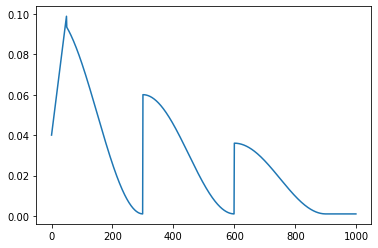

min(lrs)=0.01010, max(lrs)=0.10000


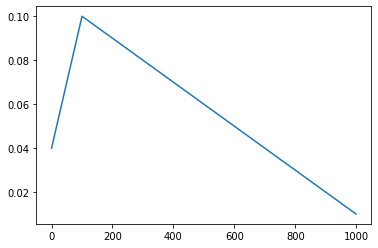

In [ ]:

fn = fn_schedule_cosine_with_warmpup_decay_timm(100,
                                                num_steps_per_epoch=10, num_epochs_per_cycle=30,num_warmup_epochs=5, cycle_decay=0.6, min_lr=0.01)
plot_lr_step_schedule(fn, 0.1, 100, 10)
fn = fn_schedule_linear_with_warmup(10, 100, 100)
plot_lr_step_schedule(fn, 0.1, 100, 10)

## LitModel

In [ ]:
#|export
class LitModel(LightningModule):
    """
        sched = fn_schedule_cosine_with_warmpup_decay_timm(
            num_epochs=EPOCHS,
            num_steps_per_epoch=len(dl_train),
            num_epochs_per_cycle=EPOCHS//2,
            min_lr=1/100,
            cycle_decay=0.7,
        )
        # plot_lr_step_schedule(sche, lr, num_epochs, step_per_epoch)
        optim = lambda params:torch.optim.Adam(params)


        model = Model()
        lit_lstm = LitLSTM(model,create_optimizer_fn=optim,
                                       create_lr_scheduler_fn=sched, loss_fn=nn.L1Loss()            
    """
    def __init__(self, model,
                 create_optimizer_fn=None,
                 create_lr_scheduler_fn=None,
                 loss_fn=nn.CrossEntropyLoss()
                ):

        super().__init__()
        store_attr()

    def configure_optimizers(self):
        """
            Setup optimizer and scheduler
        """
        assert self.create_optimizer_fn is not None

        optimizer = self.create_optimizer_fn(self.model.parameters())
        scheduler = get_scheduler(optimizer, self.create_lr_scheduler_fn)
        return [optimizer], [scheduler]

    def forward(self, x):
        return self.model(x)

    def validation_step(self, batch, batch_idx):
        x, y = batch[:2]
        logits = self(x)
        loss = self.loss_fn(logits, y)
        preds = logits.softmax(1).argmax(1)
        accs = (y == preds).float().mean()
        self.log("val_loss", loss, rank_zero_only=True, prog_bar=True,
                 on_step=False, on_epoch=True)
        self.log("val_acc", accs, rank_zero_only=True, prog_bar=True,
                 on_step=False, on_epoch=True)
        return loss

    def training_step(self, batch, batch_idx):
        x, y = batch[:2]
        logits = self(x)
        loss = self.loss_fn(logits, y)

        preds = logits.softmax(1).argmax(1)
        accs = (y == preds).float().mean()

        self.log("training_loss", loss, prog_bar=True,
                 rank_zero_only=True, on_epoch=True)
        self.log("training_accuracy", accs, prog_bar=True,
                 rank_zero_only=True, on_epoch=True)
        return loss


# Export

In [ ]:
from nbdev import nbdev_export
nbdev_export()